# Introducing Megat Computational Graph - For explainable Feature Target Relationships
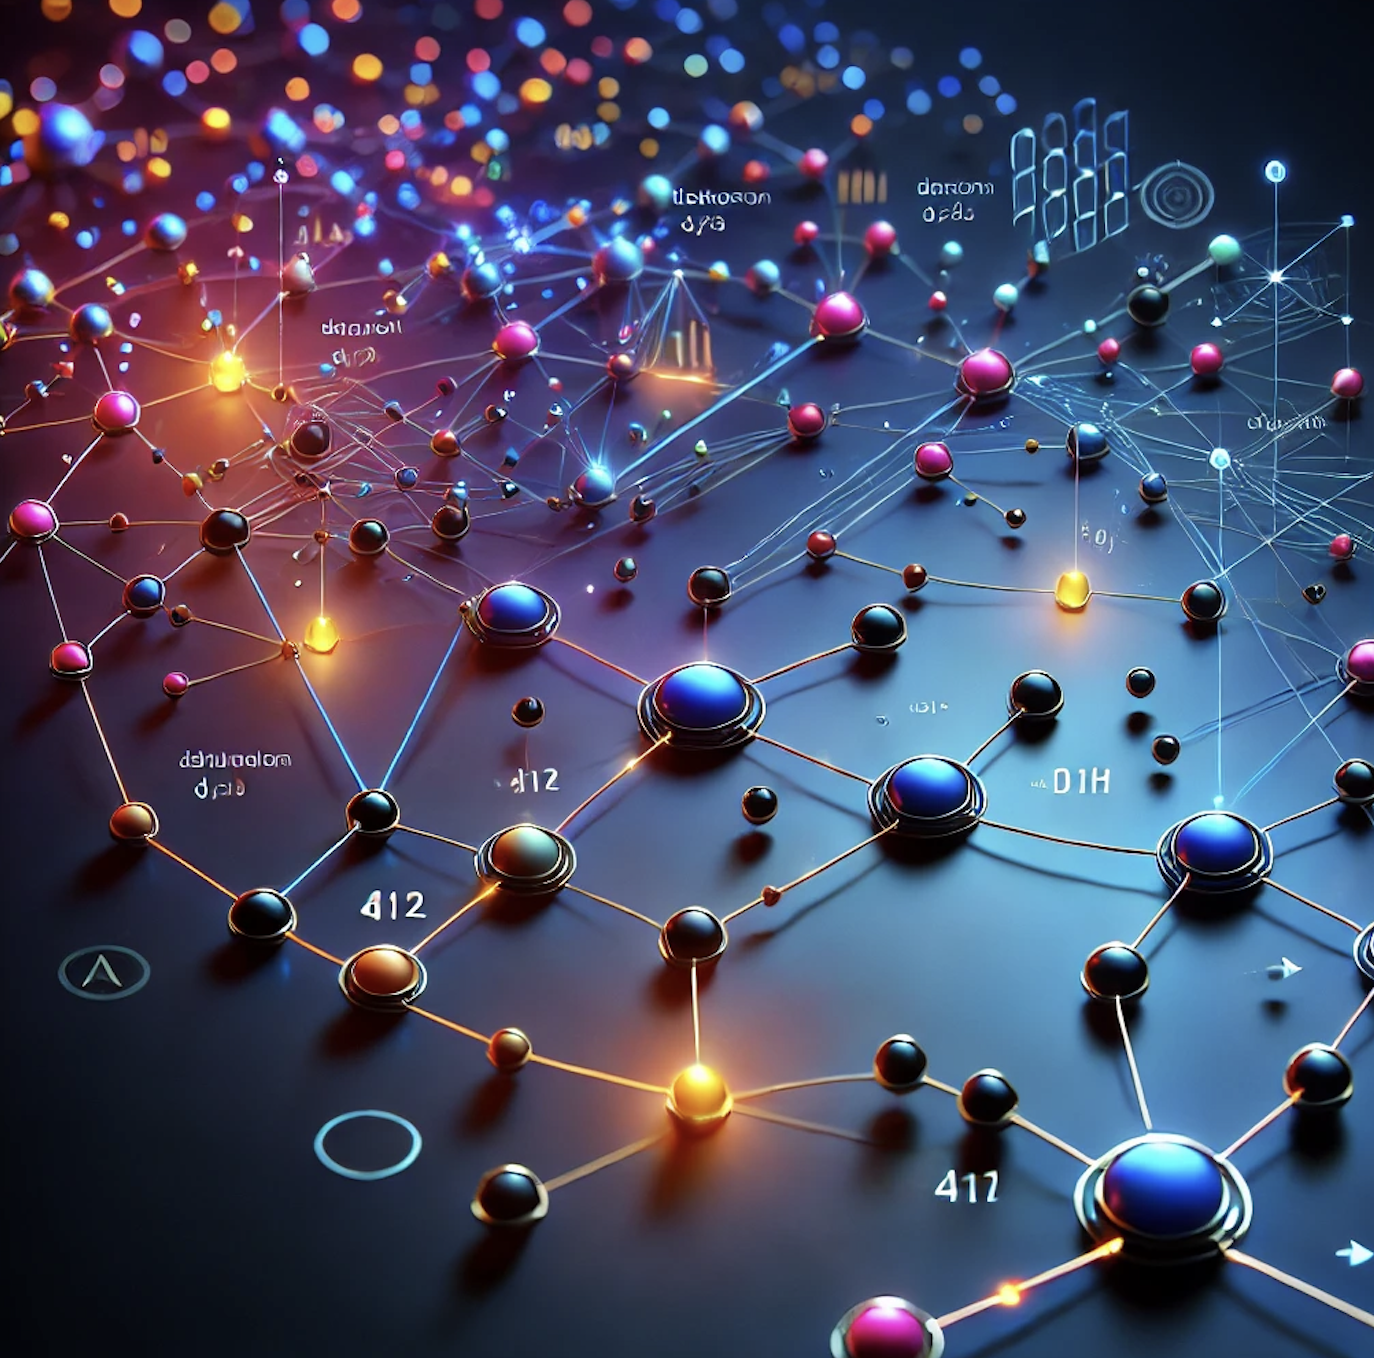

So in the past weeks I've been doing some automation for my job. I've got an excel (I still can't believe I have to deal with excel) that have a thousands of rows with tens of columns to be analyzed. Once the analysis has been done, I have to provide my insights based on the domain knowledge. This needs be done twice in a month. I don't know how many hours I've been squinting my eyes, looking at the screen, trying to make sense of the numbers. But with advent of AI and with the help of ChatGPT I see an opportunity for automation

At first, I plan to automate the analysis using SHAP (shapley additive explanations). It is quite a popular choice to use especially in explaining the relations between target and feature variables. I've tried using SHAP, but it doesn't have quite a generalized results for my data. It's kind of hit and miss.

The dataset itself has an explicit feature and target relationship. Each features contribute to the target value via simple arithmeitc operations. So it makes sense to use a more simple and explanaible approach. That's where I come up with computational graph.

## What is Computational Graph
A **computational graph** is a concept from deep learning and neural networks that breaks down complex calculations into discrete, explainable components called nodes. Each node represents a simple operation, and together they form a structure that computes a final target value. Computational graphs are specifically designed to handle intricate calculations, such as those required for the **backpropagation algorithm** used in training deep learning models. Because of their focus on managing complexity, computational graphs are generally unnecessary for simple arithmetic operations.

However, one key trait of computational graphs makes them particularly valuable for modeling the relationships between features and a target variable: **traceability**. 

With computational graphs, all features can be represented as input nodes, and their relationships with the target can be explicitly defined through intermediate calculations. This structure allows us to trace and compute the influence of each individual node (feature) on the final target. This property enables the creation of **insights automation** systems that can analyze data quickly and provide actionable insights into feature contributions.

Importantly, this approach is only effective if the relationships between features and the target are clearly defined and explicit. Below is a simple example of a computational graph in action:


Result: 3


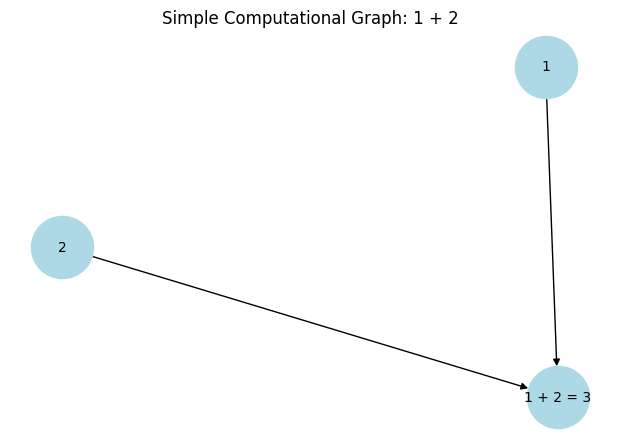

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
graph = nx.DiGraph()

# Add nodes
graph.add_node("1", value=1)  # Input 1
graph.add_node("2", value=2)  # Input 2
graph.add_node("3", operation="1 + 2")  # Result node

# Add edges to show data flow
graph.add_edge("1", "3")
graph.add_edge("2", "3")

# Compute the value at the result node
value_at_3 = 1 + 2

# Visualize the computational graph
def visualize_simple_graph(graph, result_value):
    pos = nx.spring_layout(graph)  # Layout for the graph
    node_labels = {
        "1": "1",
        "2": "2",
        "3": f"1 + 2 = {result_value}"
    }

    plt.figure(figsize=(6, 4))
    nx.draw(graph, pos, with_labels=True, labels=node_labels, node_color="lightblue", node_size=2000, font_size=10)
    plt.title("Simple Computational Graph: 1 + 2")
    plt.show()

# Print the result and visualize the graph
print(f"Result: {value_at_3}")
visualize_simple_graph(graph, value_at_3)


## Using Computational Graph to Model Feature and Target Relationships 

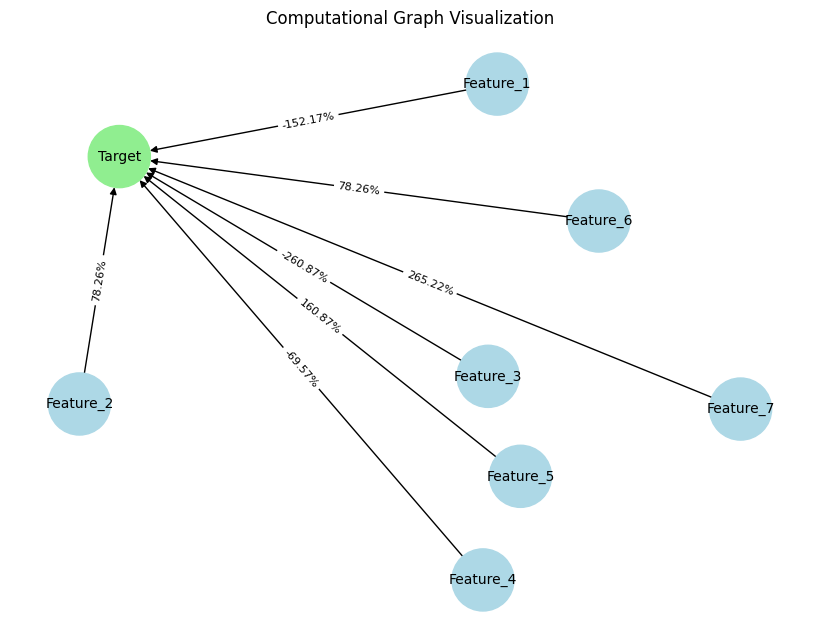

Feature  Row_1_Value  Row_2_Value  Difference  Contribution (%)
6  Feature_7           83           22         -61        265.217391
4  Feature_5           61           24         -37        160.869565
1  Feature_2           93           75         -18         78.260870
5  Feature_6           21            3         -18         78.260870
3  Feature_4           72           88          16        -69.565217
0  Feature_1           52           87          35       -152.173913
2  Feature_3           15           75          60       -260.869565

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

# Step 1: Generate random data
np.random.seed(42)  # For reproducibility
data = np.random.randint(1, 100, size=(100, 7))
columns = [f"Feature_{i+1}" for i in range(7)]
df = pd.DataFrame(data, columns=columns)

# Calculate the target as the sum of all features
df['Target'] = df.sum(axis=1)

# Step 2: Define a computational graph
def build_computational_graph(features, target):
    graph = nx.DiGraph()
    
    # Add feature nodes
    for feature in features:
        graph.add_node(feature, value=None, type="feature")
    
    # Add target node
    graph.add_node(target, value=None, type="target")
    
    # Connect features to the target node
    for feature in features:
        graph.add_edge(feature, target)
    
    return graph

# Build the computational graph
features = columns
target = "Target"
graph = build_computational_graph(features, target)

# Step 3: Compare two rows using the computational graph
row_1 = df.iloc[0]
row_2 = df.iloc[1]

# Calculate the target difference
target_diff = row_2[target] - row_1[target]

# Calculate feature contributions
feature_contributions = {}
for feature in features:
    diff = row_2[feature] - row_1[feature]
    contribution = (diff / target_diff) * 100 if target_diff != 0 else 0
    feature_contributions[feature] = contribution

# Visualize the computational graph
def visualize_graph(graph, feature_contributions):
    pos = nx.spring_layout(graph)
    plt.figure(figsize=(8, 6))
    
    # Highlight nodes
    node_colors = ["lightblue" if data["type"] == "feature" else "lightgreen" for _, data in graph.nodes(data=True)]
    nx.draw(graph, pos, with_labels=True, node_color=node_colors, node_size=2000, font_size=10)
    
    # Label edges with feature contributions
    edge_labels = {edge: f"{feature_contributions[edge[0]]:.2f}%" for edge in graph.edges if edge[0] in feature_contributions}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)
    
    plt.title("Computational Graph Visualization")
    plt.show()

# Visualize the graph with contributions
visualize_graph(graph, feature_contributions)

# Prepare and display the insights table
insights = pd.DataFrame({
    "Feature": features,
    "Row_1_Value": row_1[features].values,
    "Row_2_Value": row_2[features].values,
    "Difference": row_2[features].values - row_1[features].values,
    "Contribution (%)": [feature_contributions[feature] for feature in features]
}).sort_values(by="Contribution (%)", ascending=False)

insights
